# Soft Labeling

> How to apply soft labeling to help address noisy labels

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

## Imports

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST,force_download=True)
from sklearn.model_selection import StratifiedKFold
from numpy.random import default_rng

## Get Noisy Labels

In [2]:
x = get_image_files(path)
y = L(parent_label(o) for o in get_image_files(path))

Get 10% of the indexes to randomly change

In [3]:
n = len(x)
rng = default_rng()

noise_idxs = rng.choice(n, size=round(n*0.1), replace=False)
len(noise_idxs),noise_idxs[:5]

(7000, array([15829, 23878, 42885, 54387,  1498]))

Randomly change these so we have some bad labels

In [4]:
for i in range(0,len(noise_idxs)):
    old_path = str(x[noise_idxs[i]])
                     
    if 'training' in old_path:
        new_path = str(x[noise_idxs[i]])[:49]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[50:]
    elif 'testing' in old_path:
        new_path = str(x[noise_idxs[i]])[:48]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[49:]
        
    os.system(f'mv {old_path} {new_path}')


## Look at Data

Some of our labels are now misclassified, but we don't know which ones.  We could look at every image to find them, but that would take a ton of time.  Let's try to find the misclassified images and correct them using a pseudo labeling approach.

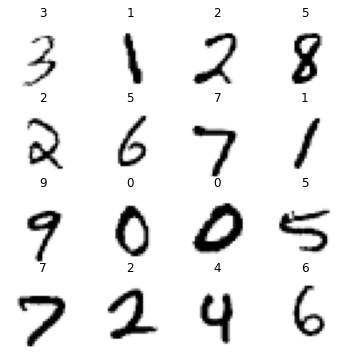

In [5]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path,bs=16)
dls.show_batch(max_n=16,figsize=(6,6))

## Create Crossfold, Train, and Predict

The reason I am doing cross folds is to get predicted labels on the training set.  The predicted labels on the training set are using labels each model was not trained on.

>Note:  I am doing this with a 2 fold, but you may want to use a 5-fold or more folds.

This cross-fold code was mostly supplied by [Zach Mueller](https://twitter.com/TheZachMueller), with minor modifications by me for this dataset and tutorial.  There is also a tutorial he wrote with more details [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Cross_Validation.ipynb)

In [6]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
splits, preds, targs, preds_c, items = [],[],[],[], []

for _, val_idx in skf.split(x,y):
    splitter = IndexSplitter(val_idx)
    splits.append(val_idx)

    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                      get_items=get_image_files, 
                      splitter=splitter,
                      get_y=parent_label)

    dls = mnist.dataloaders(path,bs=16)
    learn = cnn_learner(dls,resnet18,metrics=[accuracy,RocAuc()])
    learn.fine_tune(1,reset_opt=True)
    
    # store predictions
    p, t, c = learn.get_preds(ds_idx=1,with_decoded=True)
    preds.append(p); targs.append(t); preds_c.append(c); items.append(dls.valid.items)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.308086,1.109783,0.710429,0.920467,00:58


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.718270,0.596859,0.888200,0.948752,01:15


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.304887,1.111559,0.711486,0.921431,01:02


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.703203,0.589250,0.888800,0.949434,01:21


## Look at Predictions

Lets throw it all in a dataframe so we can look at what we have a little easier.  First, let's break out our differnt pieces of information.

In [7]:
items_flat = L(itertools.chain.from_iterable(items))
imgs = L(o for o in items_flat)
y_true = L(int(parent_label(o)) for o in items_flat) # Labels from dataset
y_targ = L(int(o) for o in torch.cat(targs)) # Labels from out predictions
y_pred = L(int(o) for o in torch.cat(preds_c)) # predicted labels or "pseudo labels"
p_max = torch.cat(preds).max(dim=1)[0] # max model score for row

We can double check we are matching things upp correctly by checking that the labels line up from the predictions and the original data.  Throwing some simple assert statements in is nice because it takes no time and it will let you know if you screw something up later as you are tinkering with things.

In [8]:
assert (y_true == y_targ) # test we matched these up correct

Put it in a dataframe and see what we have.

In [18]:
res = pd.DataFrame({'imgs':imgs,'y_true':y_true,'y_pred':y_pred}).set_index('imgs')
res.sample(5)

,y_true,y_pred
imgs,,
/home/isaacflath/.fastai/data/mnist_png/testing/4/2625.png,4,2
/home/isaacflath/.fastai/data/mnist_png/training/3/39981.png,3,3
/home/isaacflath/.fastai/data/mnist_png/training/2/36311.png,2,2
/home/isaacflath/.fastai/data/mnist_png/training/3/26814.png,3,5
/home/isaacflath/.fastai/data/mnist_png/testing/9/4633.png,9,9


# Soft Labeling Setup

Now, we have all the data we need to train a model with soft labels.  To recap we have:

1. Dataloaders with noisy labels
1. Dataframe with img path, y_true, and y_pred (pseudo labels we generated in the cross-fold above)

Now, we will need to convert things to one-hot encoding, so let's do that for our dataframe

In [ ]:
res = pd.get_dummies(res,columns=['y_true','y_pred'])

Now, lets change the Loss Function and Metric to support one hot encoded targets

In [11]:
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ.argmax(dim=axis))
    return (pred == targ).float().mean()

# Soft Labeling CallBack

Finally, lets write the callback that does the Soft Labeling.

There's a few components to this.  To put in english what is happening below in each section:

+ **before_train and before_validate:** This is grabbing the list of images for the entire dataloader.  We don't need to do this every batch, so it fits well here;
+ **before_batch:**  This filters the list of images that was defined down to only the images in our batch.  From there, it one hot encodes the y variable, and **if** it's a training batch it does y_true * 0.7 + y_pred * 0.3.  We don't want to smooth the validation set as we want a good representation of what the metrics would be on a separate test set.  This is the core of soft labeling.

The intuition for this is that the labels that the model in the crossfold got wrong above have a higher chacne of just being incorrect labels.  So we smooth those out to punish incorrect classifications less.

>Note: You can set thresholds for soft labeling to smooth more or less based on the confidence your predicted labels have.  I don't have that built into this callback, but it is something you can experiment with!

This Callback a collaboration:
+ [Zach Mueller](https://twitter.com/TheZachMueller) got me started with the callback system in fastai, particularly around dataloader batch indexing in fastai
+ [Kevin H.](https://twitter.com/kevlaouach) collaborated with me on development every step of the way.  We were working on this for a joint project, and we were both running experiments to get it to work right and perform.  A good chunk of the callback code is his.

In [10]:
class SoftLabelCB(Callback):
    def __init__(self, df_preds,y_true_weight = 0.7): 
        '''df_preds is a pandas dataframe where index is image paths
             Must have y_true and y_pred one hot encoded columns (ie y_true_0, y_true_1)
          
          imgs will need to be changed if learn.dls.train.items is a dataframe
          '''
        
        self.y_true_weight = y_true_weight
        self.y_pred_weight = 1 - y_true_weight
        self.df = df_preds

    def before_train(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.imgs_list = L(self.dl.items.iloc[:,0].values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)      
    
    def before_validate(self):
        if type(self.dl.items)==type(pd.DataFrame()): self.imgs_list = L(self.dl.items.iloc[:,0].values)
        if is_listy(self.dl.items): self.imgs_list = L(self.dl.items)       
    
    def before_batch(self):
        # get the images' names for the current batch
        imgs = self.imgs_list[self.dl._DataLoader__idxs[self.iter*self.dl.bs:self.iter*self.dl.bs+self.dl.bs]]
        
        # get soft labels
        df = self.df
        soft_labels = df.loc[imgs,df.columns.str.startswith('y_true')].values
        if self.training:
            soft_labels = soft_labels*self.y_true_weight + df.loc[imgs,df.columns.str.startswith('y_pred')].values*self.y_pred_weight

        self.learn.yb = (Tensor(soft_labels).cuda(),)

# Train the Model and Results

Then we put the callback and our one hot metric and loss function into a learning and fine tune it.  As you can see, we get a small bump in both accuracy and roc_auc score.

In [13]:
learn = cnn_learner(dls,resnet18,metrics=[accuracy,RocAuc()],loss_func=CrossEntropyLossOneHot(),cbs=SoftLabelCB(res))

In [14]:
learn.fine_tune(1,reset_opt=True)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.219303,1.060876,0.736600,0.925289,01:06


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.534213,0.594632,0.890229,0.949492,01:26
